In [55]:
# Import Library
import os
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

from sklearn.decomposition import LatentDirichletAllocation

from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [56]:
# Load data
df = pd.read_csv('D:\File Kuliah D\Semester 7\Pemro Teks\Clustering\Review_Strava_Processed_Final_Fixed.csv')


df.head()


,review,preprocessed_text,score
0,kenapa map saya eror? pace pun jadi eror juga....,eror pace eror pace gimana baik uninstall logi...,1
1,Sering tidak terekam,rekam,2
2,mantap dan gampang di gunakan,bagus gampang,5
3,akurat 👍👍,akurat,5
4,panggil aku pelari kalcer,panggil lari kalcer,5


In [57]:
# Menghapus jika ada missing value
df = df.dropna(subset=['preprocessed_text'])

In [58]:
# Vectorisasi
n_features = 5000

tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=n_features)
X_tfidf = tfidf.fit_transform(df['preprocessed_text'])

count_vec = CountVectorizer(ngram_range=(1,2), max_features=n_features)
X_counts = count_vec.fit_transform(df['preprocessed_text'])

print("TF-IDF shape:", X_tfidf.shape)
print("Count shape:", X_counts.shape)

TF-IDF shape: (1176, 5000)
Count shape: (1176, 5000)


k=2 inertia=1146.6 silhouette=0.0084
k=3 inertia=1135.4 silhouette=0.0104
k=4 inertia=1128.4 silhouette=0.0112
k=5 inertia=1124.8 silhouette=0.0092
k=6 inertia=1117.1 silhouette=0.0132
k=7 inertia=1112.5 silhouette=0.0145
k=8 inertia=1106.8 silhouette=0.0153


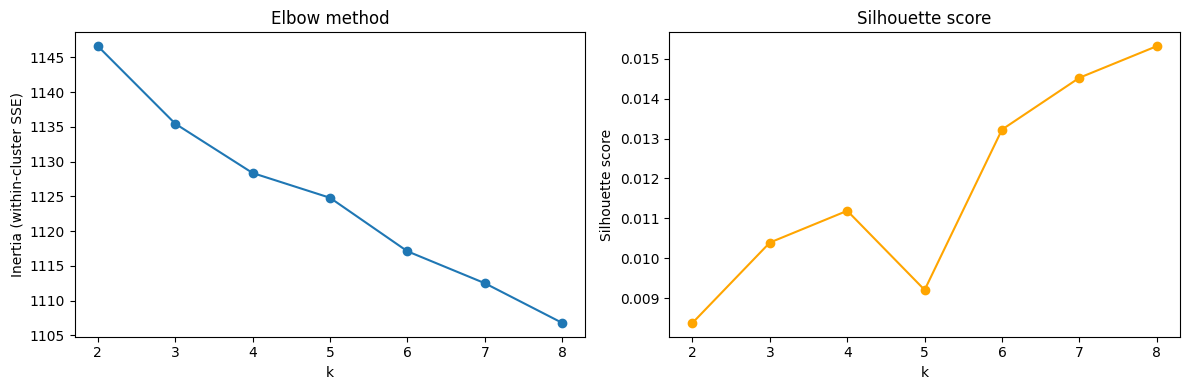

In [59]:
# Elbow & Silhouette untuk menentukan nilai K
k_range = list(range(2,9))
inertia = []
sil_scores = []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    km.fit(X_tfidf)
    inertia.append(km.inertia_)
    sil = silhouette_score(X_tfidf, km.labels_)
    sil_scores.append(sil)
    print(f"k={k} inertia={km.inertia_:.1f} silhouette={sil:.4f}")

# Plot
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(k_range, inertia, '-o')
plt.xlabel('k')
plt.ylabel('Inertia (within-cluster SSE)')
plt.title('Elbow method')

plt.subplot(1,2,2)
plt.plot(k_range, sil_scores, '-o', color='orange')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette score')
plt.tight_layout()
plt.show()


In [60]:
# Model final KMeans (setelah menentukan nilai k)
n_clusters = 4   # diubah sesuai analisis Elbow/Silhouette
km = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
km.fit(X_tfidf)
labels_km = km.labels_

# assign to df
df['kmeans_cluster'] = labels_km

# Top terms per cluster
def top_terms_per_cluster(km_model, vectorizer, n_terms=10):
    terms = vectorizer.get_feature_names_out()
    order_centroids = km_model.cluster_centers_.argsort()[:, ::-1]
    info = {}
    for i in range(km_model.n_clusters):
        top = [terms[ind] for ind in order_centroids[i, :n_terms]]
        info[i] = top
        print(f"Cluster {i}: {', '.join(top)}")
    return info

top_terms = top_terms_per_cluster(km, tfidf, n_terms=12)


Cluster 0: olahraga, bantu, manfaat, bagus, aplikasi, aktivitas olahraga, semangat, semangat olahraga, bantu olahraga, aktivitas, olahraga lari, lari
Cluster 1: aplikasi, strava, login, lari, baik, tolong, error, pace, bantu, akurat, jarak, eror
Cluster 2: dana, kembali, uang, langgan, saldo, tolong, tolong kembali, kembali dana, kembali uang, mohon, tarik, saldo dana
Cluster 3: bagus, aplikasi bagus, aplikasi, bagus banget, banget, bagus aplikasi, lari, gratis, bagus bantu, bantu, running, bagus bagus


c:\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


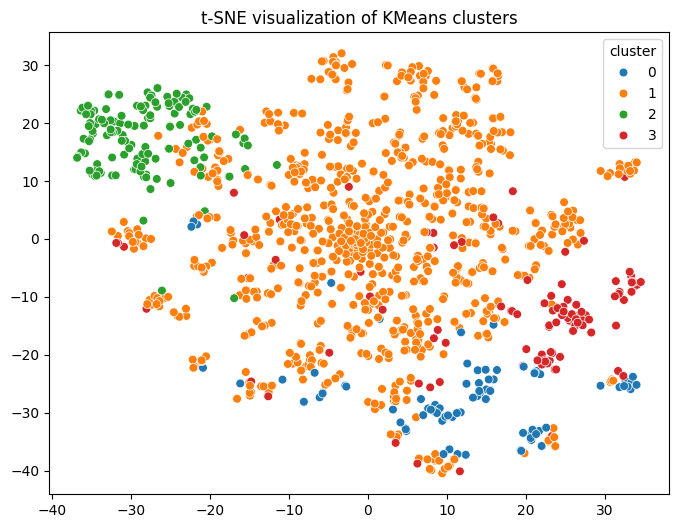

In [61]:
# 2D visualization using TruncatedSVD (for sparse) then t-SNE
svd = TruncatedSVD(n_components=50, random_state=42)
X_red = svd.fit_transform(X_tfidf)

tsne = TSNE(n_components=2, random_state=42, perplexity=40, n_iter=1000, init='pca')
X_tsne = tsne.fit_transform(X_red)

plt.figure(figsize=(8,6))
palette = sns.color_palette('tab10', n_clusters)
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=labels_km, palette=palette, legend='full', s=40)
plt.title('t-SNE visualization of KMeans clusters')
plt.legend(title='cluster')
plt.show()


In [ ]:
# LDA (sklearn) on CountVectorizer
n_topics = 5
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=20, random_state=42)
lda.fit(X_counts)

# show top words per topic
def show_topics(model, vectorizer, topn=12):
    words = vectorizer.get_feature_names_out()
    topics = {}
    for idx, topic in enumerate(model.components_):
        top_indices = topic.argsort()[-topn:][::-1]
        top_words = [words[i] for i in top_indices]
        topics[idx] = top_words
        print(f"Topic {idx}: {', '.join(top_words)}")
    return topics

lda_topics = show_topics(lda, count_vec, topn=12)


Topic 0: strava, tolong, langgan, aplikasi, dana, eror, olahraga, uang, saldo, masuk, login, bantu
Topic 1: aplikasi, tolong, olahraga, dana, lari, akurat, kembali, aktivitas, bagus, bayar, strava, banget
Topic 2: aplikasi, login, bagus, error, strava, baik, pace, tolong, server, banget, pake, lari
Topic 3: dana, kembali, langgan, strava, aplikasi, lari, kembali dana, tolong, potong, jarak, bantu, akurat
Topic 4: aplikasi, tolong, kembali, lari, uang, dana, bagus, bantu, strava, langgan, saldo, mohon


In [63]:
# assign dominant topic per doc
doc_topic_dist = lda.transform(X_counts)  # shape (n_docs, n_topics)
dominant_topic = doc_topic_dist.argmax(axis=1)

df['lda_topic'] = dominant_topic
# optional: store topic probability
df['lda_topic_prob'] = doc_topic_dist.max(axis=1)

# show counts per topic
print("Documents per topic:")
print(pd.Series(dominant_topic).value_counts().sort_index())


Documents per topic:
0    222
1    238
2    286
3    102
4    328
Name: count, dtype: int64
